In [1]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

Populating the interactive namespace from numpy and matplotlib


C:\Users\nikhi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# AutoCoder

A convolutional autoencoder is a particular 
flavor of autoencoder where we
use convolutional layers instead of dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should be
able to do better using convolutional layers instead of Dense layers.
Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we have used
with convolutional classiifcation networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.
An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.
After training your network, visualize some examples of input images and
their decoded reconstruction.

### Load the data

In [2]:
import tensorflow as tf
import keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [3]:
X_train.shape

(60000, 28, 28, 1)

### CNN model architecture

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [16]:
from keras.callbacks import TensorBoard
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 115s 2ms/step - loss: 0.3712 - val_loss: 0.3350
Epoch 2/5
60000/60000 [==============================] - 111s 2ms/step - loss: 0.3273 - val_loss: 0.3226
Epoch 3/5
60000/60000 [==============================] - 114s 2ms/step - loss: 0.3178 - val_loss: 0.3169
Epoch 4/5
60000/60000 [==============================] - 111s 2ms/step - loss: 0.3121 - val_loss: 0.3100
Epoch 5/5
60000/60000 [==============================] - 109s 2ms/step - loss: 0.3084 - val_loss: 0.3065


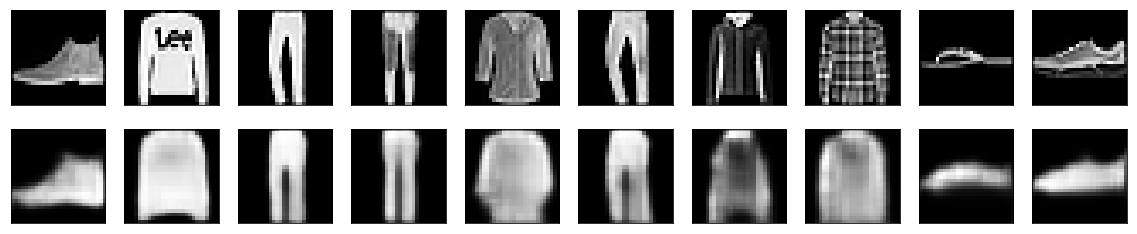

In [17]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()